In [4]:
"""
Module to train the GNN model. All config data must have been added to /src/config.ini file prior
to executing this script. A model.dat file will be created in the first run, and automatically 
loaded again in the following runs.
"""

from data import load_csv_to_df, sample_df 
from graph import create_hetero_graph
from model import GNN, run_model_for_graphs_list 
import torch
import configparser   # 파라미터 정리를 위해 
from sklearn.utils import shuffle #data 셔플링
from torch_geometric.loader import DataLoader #데이터Loader
import numpy as np
import matplotlib.pyplot as plt



config = configparser.ConfigParser()
config.read("./config.ini")


['./config.ini']

In [5]:

# Training 데이터 Load
df = load_csv_to_df(
    config["PARAMETERS"]["DataFolderPath"] + config["PARAMETERS"]["TrainFile"])

# 데이터 셔플
df = shuffle(df)
df.reset_index(inplace=True)


# 데이터 Sampling
df = sample_df(df, sample_rate=float(
    config["PARAMETERS"]["TrainSampleRate"]))




n_nodes = int(config["PARAMETERS"]["NumberOfNodes"]) #node 수
total = len(df) #전체 dataset 길이

#그래프 생성
graphs = []

for i in range(int(total/n_nodes)): 
    initial = i*n_nodes
    final = (i+1)*n_nodes
    temp = df[initial:final]

    graphs.append(create_hetero_graph(temp))

print(graphs)


[HeteroData(
  host_ip_port={ x=[1445, 128] },
  host_ip={ x=[207, 128] },
  connection={
    x=[998, 5],
    y=[998]
  },
  (host_ip, to, host_ip_port)={ edge_index=[2, 2000] },
  (host_ip_port, to, connection)={ edge_index=[2, 2000] },
  (connection, to, host_ip_port)={ edge_index=[2, 2000] },
  (host_ip_port, to, host_ip)={ edge_index=[2, 2000] }
), HeteroData(
  host_ip_port={ x=[1420, 128] },
  host_ip={ x=[186, 128] },
  connection={
    x=[999, 5],
    y=[999]
  },
  (host_ip, to, host_ip_port)={ edge_index=[2, 2000] },
  (host_ip_port, to, connection)={ edge_index=[2, 2000] },
  (connection, to, host_ip_port)={ edge_index=[2, 2000] },
  (host_ip_port, to, host_ip)={ edge_index=[2, 2000] }
), HeteroData(
  host_ip_port={ x=[1404, 128] },
  host_ip={ x=[193, 128] },
  connection={
    x=[1000, 5],
    y=[1000]
  },
  (host_ip, to, host_ip_port)={ edge_index=[2, 2000] },
  (host_ip_port, to, connection)={ edge_index=[2, 2000] },
  (connection, to, host_ip_port)={ edge_index=[2, 20

In [7]:
df[' Label'].value_counts()

 Label
PortScan    15815
BENIGN      12832
Name: count, dtype: int64

Loading model...
Starting training phase...
Training epoch: 1
Graph 0: 0.6922612190246582
Graph 1: 0.6922731995582581
Graph 2: 0.6952161192893982
Graph 3: 0.6935950517654419
Graph 4: 0.694266676902771
Graph 5: 0.6938163638114929
Graph 6: 0.7020158171653748
Graph 7: 0.7101350426673889
Graph 8: 0.712057888507843
Graph 9: 0.7471950650215149
Graph 10: 0.7223488688468933
Graph 11: 0.7323260307312012
Graph 12: 0.7178462147712708
Graph 13: 0.7149304151535034
Graph 14: 0.6817969083786011
Graph 15: 0.6846776008605957
Graph 16: 0.6438778638839722
Graph 17: 0.6294969320297241
Graph 18: 0.6105544567108154
Graph 19: 0.6029407382011414
Graph 20: 0.5972113013267517
Graph 21: 0.5878574848175049
Graph 22: 0.8649503588676453
Graph 23: 0.5889078378677368
Graph 24: 0.5977472066879272
Graph 25: 0.8834119439125061
Graph 26: 0.8667116761207581
Graph 27: 0.5855697989463806
Training epoch: 2
Graph 0: 0.8666292428970337
Graph 1: 0.8714606165885925
Graph 2: 0.5862472653388977
Graph 3: 0.5942655205726624
Graph 4:

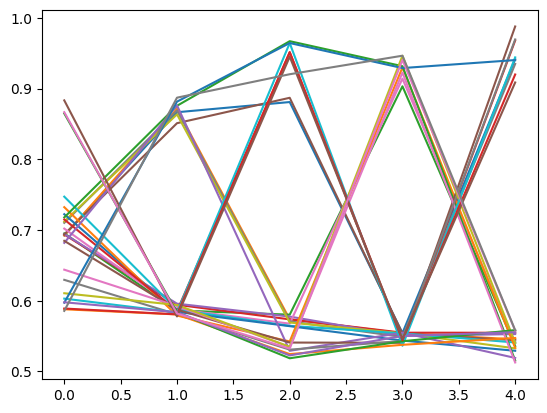

In [6]:

loader = DataLoader(graphs, batch_size=1, shuffle=True)


# Initialize model
model = GNN(
    input_channels=int(config["PARAMETERS"]["NInputFeatures"]),
    hidden_channels=128,
    output_channels=int(config["PARAMETERS"]["NClasses"]),
    dropout=0)

# Load state dict of saves model
try:
    model.load_state_dict(torch.load(config["PARAMETERS"]["ModelPath"]))
    print("Loading model...")
except FileNotFoundError:
    print("Creating new model...")

# Model parameters
train_epochs = int(config["PARAMETERS"]["NTrainEpochs"])
optimizer = torch.optim.Adam(
    model.parameters(), lr=1e-3, weight_decay=5e-4)

# Run model
print("Starting training phase...")
loss_arr = run_model_for_graphs_list(
    model, loader, optimizer, train_epochs, len(graphs))

# Plot Loss curve
for i in range(len(graphs)):
    plt.plot(np.arange(train_epochs), loss_arr[i, :])
plt.show()

# Save model state
torch.save(model.state_dict(), config["PARAMETERS"]["ModelPath"])

